In [1]:
!pip install yfinance pandas matplotlib statsmodels

##ARIMA

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [3]:
ticker = 'AAPL'
data = yf.download(ticker, start='2022-01-01', end=datetime.today().strftime('%Y-%m-%d'))

# Use only the 'Close' price for prediction
df = data['Close']
df = df.asfreq('B')  # Ensure business-day frequency
df = df.ffill()  # Fill missing values

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


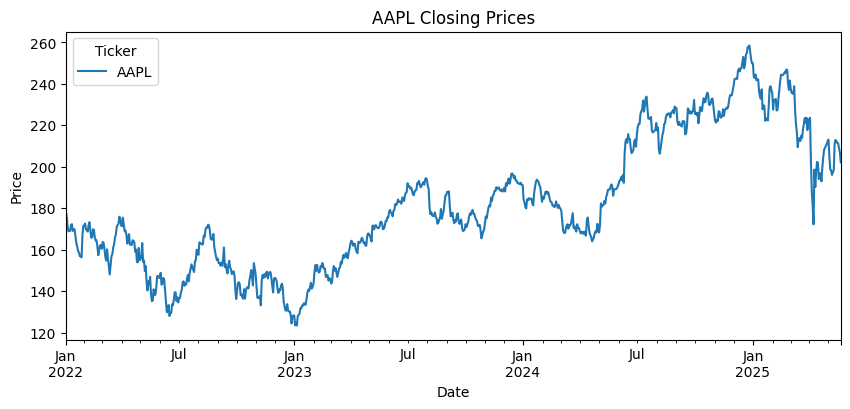

In [4]:
df.plot(title=f"{ticker} Closing Prices", figsize=(10, 4))
plt.ylabel('Price')
plt.show()

In [5]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [10]:
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


MSE: 389.0645
RMSE: 19.7247
R² Score: -0.4741


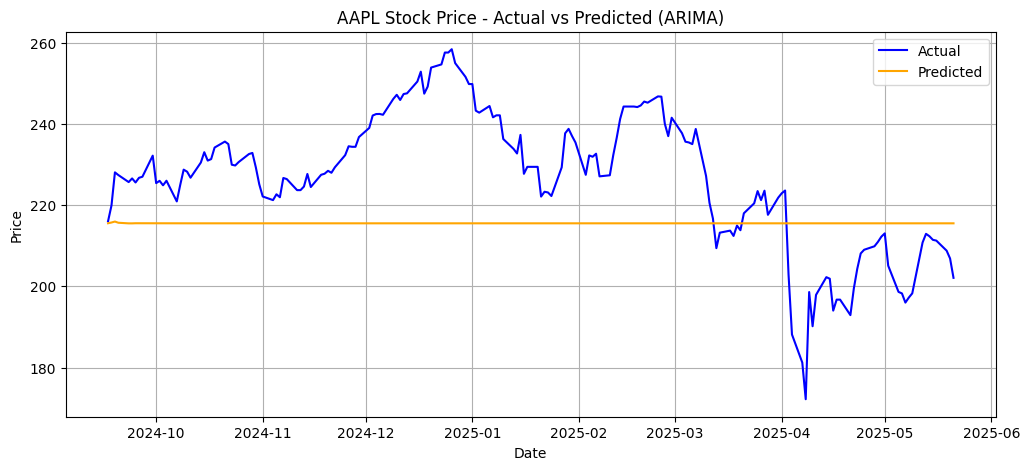

In [11]:
start = test.index[0]
end = test.index[-1]
predictions = model_fit.predict(start=start, end=end, typ='levels')

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test, predictions)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title(f'{ticker} Stock Price - Actual vs Predicted (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

##Facebook Prophet

In [12]:
from prophet import Prophet

In [13]:
ticker = 'AAPL'
data = yf.download(ticker, start='2018-01-01', end='2024-12-31')


df = pd.DataFrame({
        'ds': data.index,
        'y': data['Close'].squeeze()
    })

[*********************100%***********************]  1 of 1 completed


In [14]:
model = Prophet(daily_seasonality=True)
print(df.shape)
model.fit(df.squeeze())

DEBUG:cmdstanpy:input tempfile: /tmp/tmpte4zav1f/fbib2snd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpte4zav1f/0ovlxftc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=564', 'data', 'file=/tmp/tmpte4zav1f/fbib2snd.json', 'init=/tmp/tmpte4zav1f/0ovlxftc.json', 'output', 'file=/tmp/tmpte4zav1f/prophet_modelf58jqg2n/prophet_model-20250522041932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


(1760, 2)


04:19:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

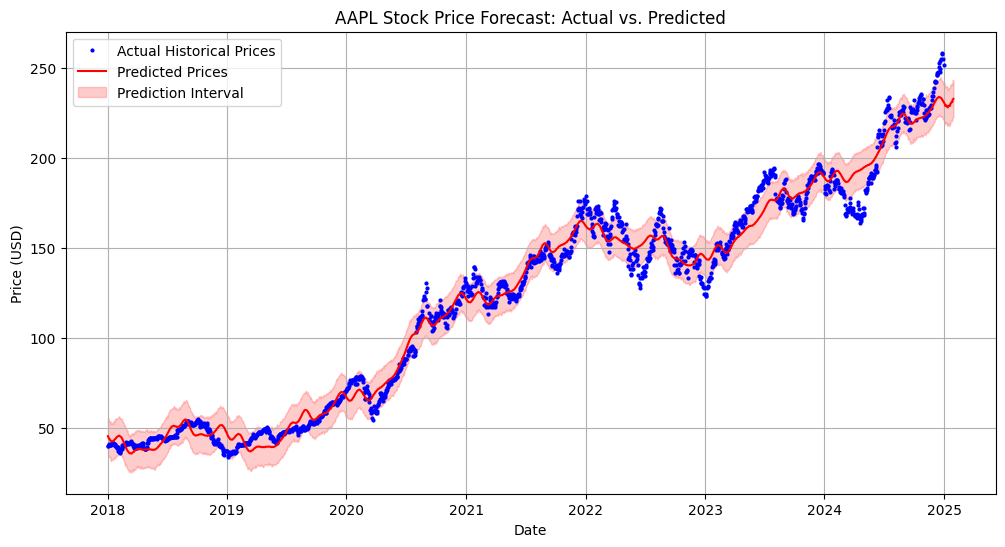

In [17]:
plt.figure(figsize=(12, 6))

# Plot actual values (historical data)
plt.plot(df['ds'], df['y'], 'o', color='blue', label='Actual Historical Prices', markersize=2)
plt.plot(forecast['ds'], forecast['yhat'], color='red', label='Predicted Prices')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='red', alpha=0.2, label='Prediction Interval')

plt.title(f"{ticker} Stock Price Forecast: Actual vs. Predicted")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 1: Align predicted and actual values on common dates
# Merge forecast with original df on 'ds'
merged = df.merge(forecast[['ds', 'yhat']], on='ds')

# Step 2: Extract actual and predicted values
y_true = merged['y']
y_pred = merged['yhat']

# Step 3: Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Step 4: Print the results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MSE: 63.1908
RMSE: 7.9493
R² Score: 0.9819


##LSTM

#EPOCH 20

In [22]:
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

In [25]:
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end=datetime.today().strftime('%Y-%m-%d'))
data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [26]:
stock_close = data[['Close']].copy()
dataset = stock_close.values
training_data_len = int(np.ceil(len(dataset) * 0.80))

scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len]

X_train, y_train = [], []
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

model.summary()
model.compile(optimizer="adam", loss="mae", metrics=[keras.metrics.RootMeanSquaredError()])

# 6. Train the Model
model.fit(X_train, y_train, epochs=20, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.3163 - root_mean_squared_error: 0.4025
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.1191 - root_mean_squared_error: 0.1544
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1123 - root_mean_squared_error: 0.1436
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0983 - root_mean_squared_error: 0.1271
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0956 - root_mean_squared_error: 0.1253
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.1001 - root_mean_squared_error: 0.1301
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0978 - root_mean_squared_error: 0.1276
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1011 - root_mean_squared_error: 0.1298
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0976 - root_mean_squared_error: 0.1258
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0930 - root_mean_squared_error: 0.1194

In [28]:
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 8. Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


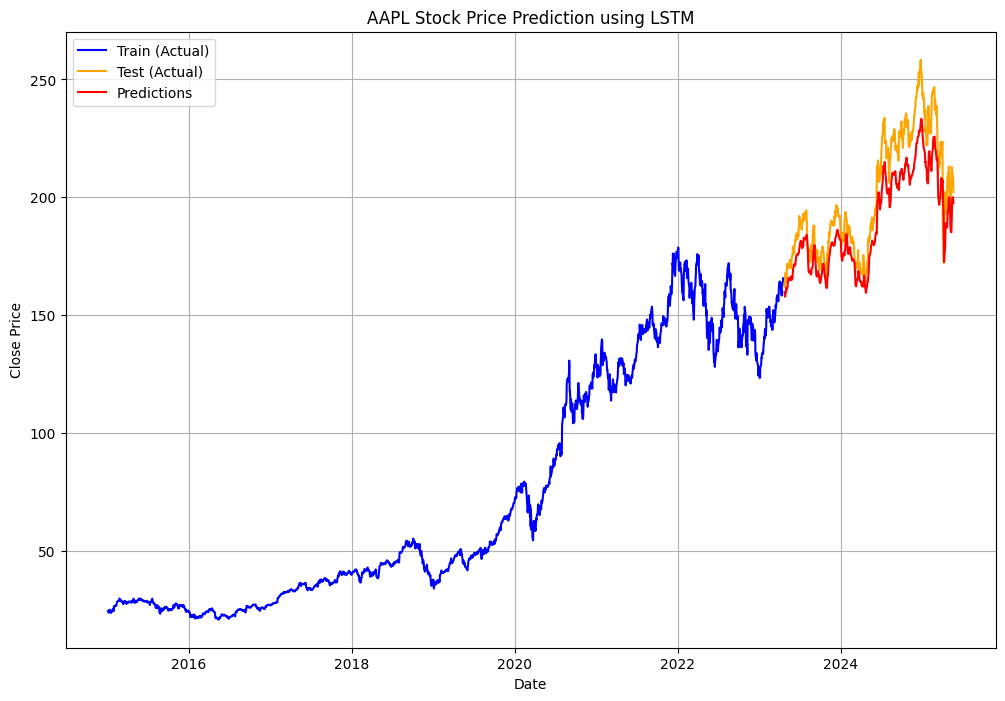

In [29]:
train = data[:training_data_len]
test = data[training_data_len:].copy()
test['Predictions'] = predictions

# 10. Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train['Date'], train['Close'], label="Train (Actual)", color='blue')
plt.plot(test['Date'], test['Close'], label="Test (Actual)", color='orange')
plt.plot(test['Date'], test['Predictions'], label="Predictions", color='red')
plt.title(f"{ticker} Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


R² Score: 0.7189
MSE: 174.5218
RMSE: 13.2107


In [31]:
print(test[['Date','Close','Predictions']])

Price        Date       Close Predictions
Ticker                   AAPL            
2090   2023-04-24  163.464966  159.674301
2091   2023-04-25  161.922577  159.273849
2092   2023-04-26  161.912689  158.497726
2093   2023-04-27  166.510239  157.784821
2094   2023-04-28  167.765900  158.486847
...           ...         ...         ...
2607   2025-05-15  211.449997  197.571243
2608   2025-05-16  211.259995  199.460541
2609   2025-05-19  208.779999  200.049622
2610   2025-05-20  206.860001  199.208328
2611   2025-05-21  202.089996  197.505859

[522 rows x 3 columns]


#EPOCH 30

In [36]:
model1 = keras.models.Sequential()
model1.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model1.add(keras.layers.LSTM(64, return_sequences=False))
model1.add(keras.layers.Dense(128, activation="relu"))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(1))

model1.summary()
model1.compile(optimizer="adam", loss="mae", metrics=[keras.metrics.RootMeanSquaredError()])

# 6. Train the Model
model1.fit(X_train, y_train, epochs=30, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.3333 - root_mean_squared_error: 0.4177
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.1176 - root_mean_squared_error: 0.1497
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.1045 - root_mean_squared_error: 0.1341
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0987 - root_mean_squared_error: 0.1288
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0971 - root_mean_squared_error: 0.1242
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0941 - root_mean_squared_error: 0.1211
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0996 - root_mean_squared_error: 0.1270
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0973 - root_mean_squared_error: 0.1258
Epoch 9/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0924 - root_mean_squared_error: 0.1174
Epoch 10/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0936 - root_mean_squared_error: 0.119

In [37]:
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 8. Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


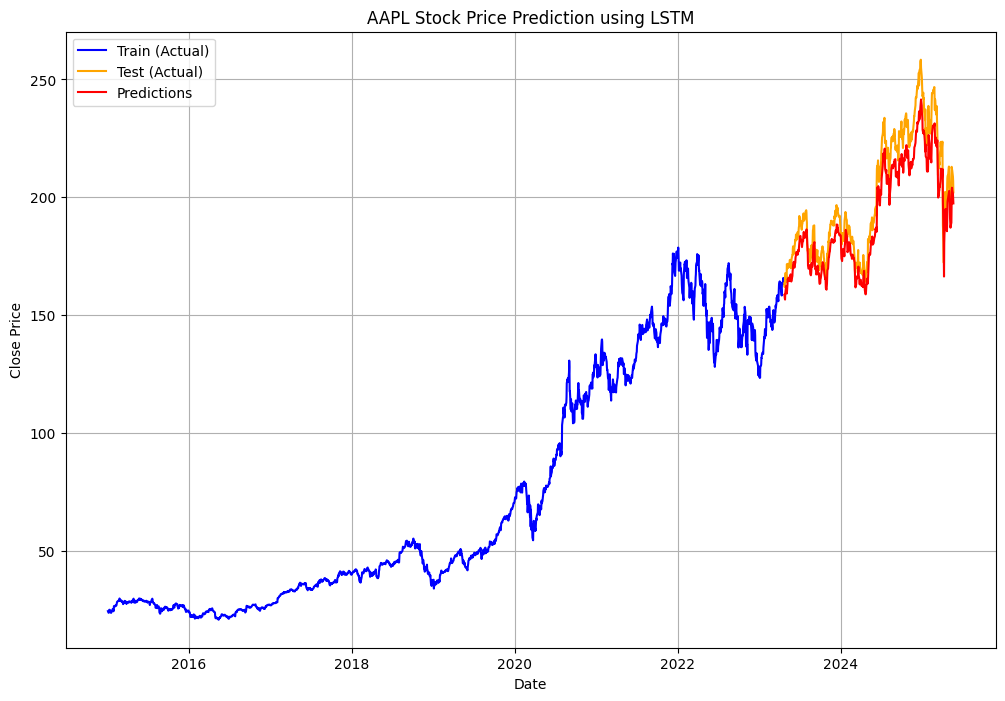

In [38]:
train = data[:training_data_len]
test = data[training_data_len:].copy()
test['Predictions'] = predictions

# 10. Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train['Date'], train['Close'], label="Train (Actual)", color='blue')
plt.plot(test['Date'], test['Close'], label="Test (Actual)", color='orange')
plt.plot(test['Date'], test['Predictions'], label="Predictions", color='red')
plt.title(f"{ticker} Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


R² Score: 0.8339
MSE: 103.1471
RMSE: 10.1561


In [40]:
print(test[['Date','Close','Predictions']])

Price        Date       Close Predictions
Ticker                   AAPL            
2090   2023-04-24  163.464966  158.594940
2091   2023-04-25  161.922577  158.079758
2092   2023-04-26  161.912689  157.042999
2093   2023-04-27  166.510239  156.575363
2094   2023-04-28  167.765900  159.216904
...           ...         ...         ...
2607   2025-05-15  211.449997  204.063995
2608   2025-05-16  211.259995  202.778610
2609   2025-05-19  208.779999  201.667099
2610   2025-05-20  206.860001  199.499786
2611   2025-05-21  202.089996  197.395157

[522 rows x 3 columns]


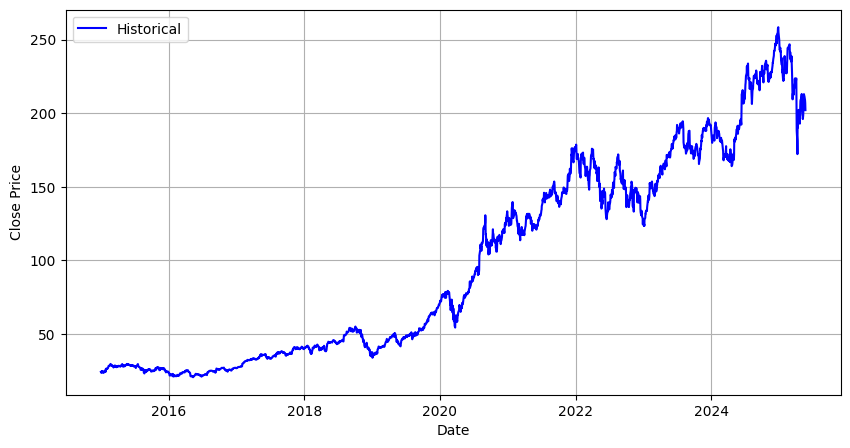

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Close'], label="Historical", color="blue")
#plt.plot(future_dates, forecasted_prices, label="7-Day Forecast", color="green", marker='o')
#plt.title(f"{ticker} Stock Price - Next 7 Days Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
last_60_days = scaled_data[-60:]  # shape = (60, 1)
forecast_input = last_60_days.copy()
forecast_input.shape

(60, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


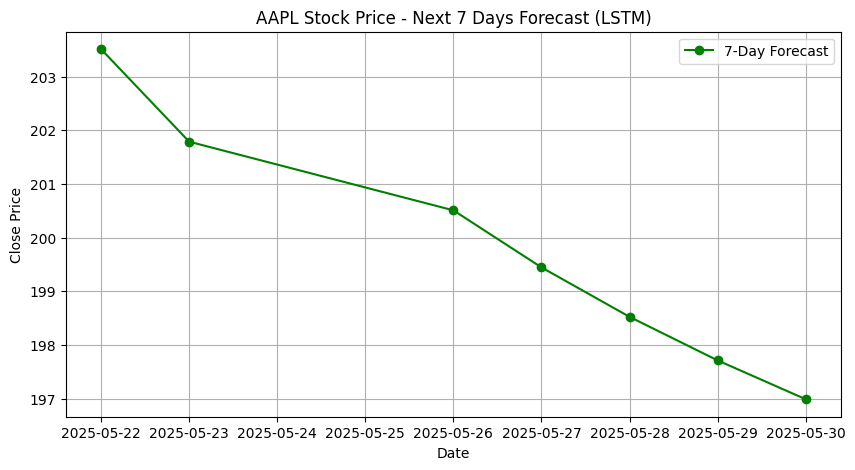

In [47]:
forecast_input = forecast_input.reshape(1, 60, 1)

forecasted = []

for _ in range(7):
    next_pred = model1.predict(forecast_input)[0][0]
    forecasted.append(next_pred)

    # Update forecast_input with new prediction
    forecast_input = np.append(forecast_input[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse transform the forecasted scaled values back to original prices
forecasted_prices = scaler.inverse_transform(np.array(forecasted).reshape(-1, 1)).flatten()

# Generate future dates
last_date = data['Date'].iloc[-1]
future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=7)

# Plot future predictions
plt.figure(figsize=(10, 5))
plt.plot(future_dates, forecasted_prices, label="7-Day Forecast", color="green", marker='o')
plt.title(f"{ticker} Stock Price - Next 7 Days Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [48]:
for d, p in zip(future_dates, forecasted_prices):
    print(f"{d.date()}: ${p:.2f}")

2025-05-22: $203.51
2025-05-23: $201.79
2025-05-26: $200.51
2025-05-27: $199.44
2025-05-28: $198.52
2025-05-29: $197.71
2025-05-30: $196.99


##Comparison of ARIMA, Facebook Prophet, LSTM

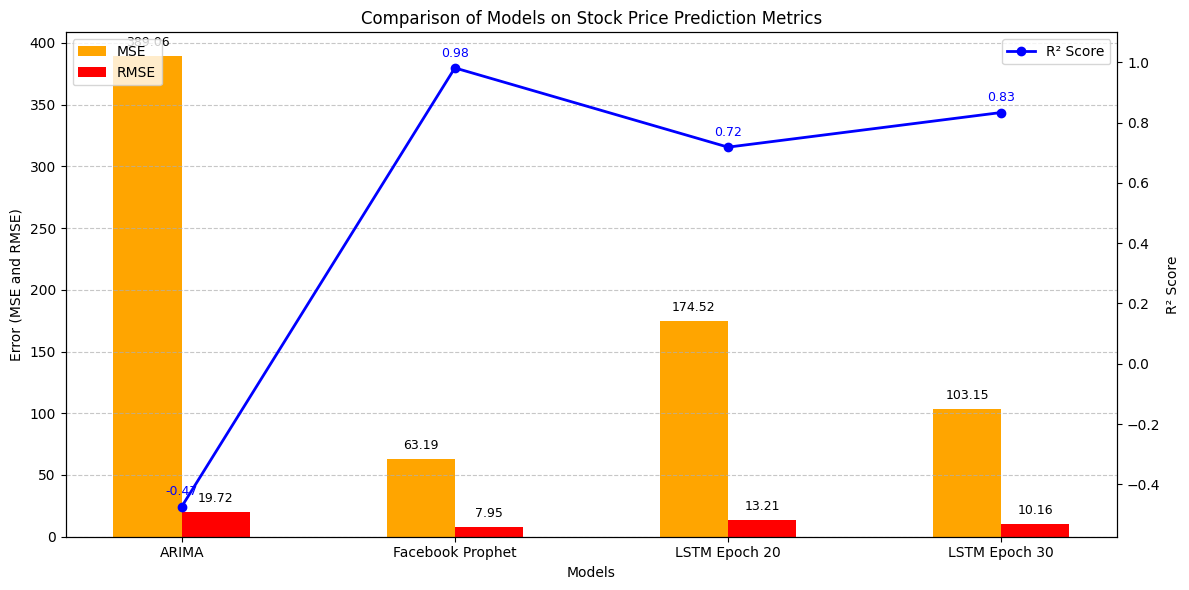

In [49]:
import matplotlib.pyplot as plt
import numpy as np

models = ['ARIMA', 'Facebook Prophet', 'LSTM Epoch 20', 'LSTM Epoch 30']

# Metrics
r2_scores = [-0.4741, 0.9819, 0.7189, 0.8339]
mses = [389.0645, 63.1908, 174.5218, 103.1471]
rmses = [19.7247, 7.9493, 13.2107, 10.1561]

x = np.arange(len(models))  # label locations
width = 0.25  # bar width

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MSE and RMSE on primary y-axis
rects1 = ax1.bar(x - width/2, mses, width, label='MSE', color='orange')
rects2 = ax1.bar(x + width/2, rmses, width, label='RMSE', color='red')

ax1.set_ylabel('Error (MSE and RMSE)')
ax1.set_xlabel('Models')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title('Comparison of Models on Stock Price Prediction Metrics')

ax1.legend(loc='upper left')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Create second y-axis for R² scores
ax2 = ax1.twinx()
ax2.plot(x, r2_scores, color='blue', marker='o', linestyle='-', linewidth=2, label='R² Score')
ax2.set_ylabel('R² Score')
ax2.set_ylim(min(r2_scores) - 0.1, 1.1)
ax2.legend(loc='upper right')

# Annotate values on bars and line points
def annotate_bars(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

annotate_bars(rects1, ax1)
annotate_bars(rects2, ax1)

for i, val in enumerate(r2_scores):
    ax2.annotate(f'{val:.2f}', xy=(x[i], val), xytext=(0,8),
                 textcoords='offset points', ha='center', fontsize=9, color='blue')

plt.tight_layout()
plt.show()
